Metric Learning on MNIST using PyTorch.

STEPS:
- Train a fully connected using MNIST

- The architecture of NN: 786, 256, 2, 10

- Why 2 neurons at the pre-final layer?
    - Because we want to show embeddings of each image in 2D..

- Visualize embedding
    - Mostly elongated clusters.

- Same exercise for CNN with 2 neurons at pre-final layer

- Similar visualization

- Train Siamese network
    - Dataset class implementation
    - Custom Loss function
    - Difference between train-time and test-time

- Visualize embeddings
    - Clusters with nice circular shape can be visualized.

- Repeat training and visualization for Triplet network
    - Training is faster. Clusters are better than siamese.
    
- Use trained NN on Jetson Nano for inference

# Imports

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn.functional as F

/home/yasin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Few hyper-parametes

In [2]:
num_epochs = 50
batch_size = 4096
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST dataset provided in pytorch for training and validation

In [4]:
transforms_ = transforms.ToTensor()
train_data = datasets.MNIST(root='/media/yasin/other/datasets/mnist/', train=True, transform=transforms_, download=False)
test_data = datasets.MNIST(root='/media/yasin/other/datasets/mnist/', train=False, transform=transforms_, download=False)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Fully connected NN

In [4]:
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet,self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(2, 10)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(2)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.bn1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.bn3(out)
        out = self.fc4(out)
        return out

# Train Fully connected NN

In [5]:
classifier_fc = FullyConnectedNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_fc.parameters(), lr=1e-1)

for epoch in range(num_epochs):
    running_loss_train = 0.
    running_corrects_train = 0
    classifier_fc.train()
    for i ,(images,labels) in enumerate(train_loader):    
        images = images.view(-1,28*28).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = classifier_fc(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss_train += loss.item() * images.size(0)
        running_corrects_train += torch.sum(preds == labels.data)
    epoch_loss_train = running_loss_train / len(train_data)
    epoch_acc_train = running_corrects_train.double() / len(train_data)

    classifier_fc.eval()
    running_loss_test = 0.
    running_corrects_test = 0
    for i ,(images,labels) in enumerate(test_loader):    
        images = images.view(-1,28*28).to(device)
        labels = labels.to(device)
        outputs = classifier_fc(images)
        loss = loss_function(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss_test += loss.item() * images.size(0)
        running_corrects_test += torch.sum(preds == labels.data)
    epoch_loss_test = running_loss_test / len(test_data)
    epoch_acc_test = running_corrects_test.double() / len(test_data)         

    print(f'Epoch {epoch+1}/{num_epochs}\t'
          f'Train loss: {epoch_loss_train:.4f} | '
          f'Train accuracy: {epoch_acc_train:.4f} | '
          f'Test loss: {epoch_loss_test:.4f} | '
          f'Test accuracy: {epoch_acc_test:.4f}')

Epoch 1/50	Train loss: 1.6621 | Train accuracy: 0.3987 | Test loss: 5.5250 | Test accuracy: 0.2684
Epoch 2/50	Train loss: 0.9066 | Train accuracy: 0.6804 | Test loss: 3.8545 | Test accuracy: 0.2652
Epoch 3/50	Train loss: 0.6020 | Train accuracy: 0.8226 | Test loss: 1.8739 | Test accuracy: 0.4613
Epoch 4/50	Train loss: 0.4515 | Train accuracy: 0.8795 | Test loss: 0.5648 | Test accuracy: 0.8344
Epoch 5/50	Train loss: 0.3644 | Train accuracy: 0.9072 | Test loss: 0.3992 | Test accuracy: 0.8981
Epoch 6/50	Train loss: 0.3087 | Train accuracy: 0.9210 | Test loss: 0.4191 | Test accuracy: 0.8883
Epoch 7/50	Train loss: 0.2709 | Train accuracy: 0.9304 | Test loss: 0.3452 | Test accuracy: 0.9152
Epoch 8/50	Train loss: 0.2442 | Train accuracy: 0.9371 | Test loss: 0.3779 | Test accuracy: 0.9089
Epoch 9/50	Train loss: 0.2228 | Train accuracy: 0.9413 | Test loss: 0.4230 | Test accuracy: 0.8880
Epoch 10/50	Train loss: 0.1957 | Train accuracy: 0.9487 | Test loss: 0.3059 | Test accuracy: 0.9341
Epoch 11/

We are going to visualize the features extracted by fully connected NN in pre-final layer. Our initial implentation does not return features in forward method, so we are writing new class for fully connected NN. We will copy weights of trained NN in newly implemented NN class.

In [6]:
class FullyConnectedNet_features(nn.Module):
    def __init__(self):
        super(FullyConnectedNet_features,self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)
        self.fc4 = nn.Linear(2, 10)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(2)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.bn1(out)
        out = self.fc2(out)
        features = out
        out = self.relu(out)
        out = self.bn3(out)
        out = self.fc4(out)
        return out, features

Colors for vizualization

In [15]:
clr = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

# Plot 2D features learnt by fully connected NN

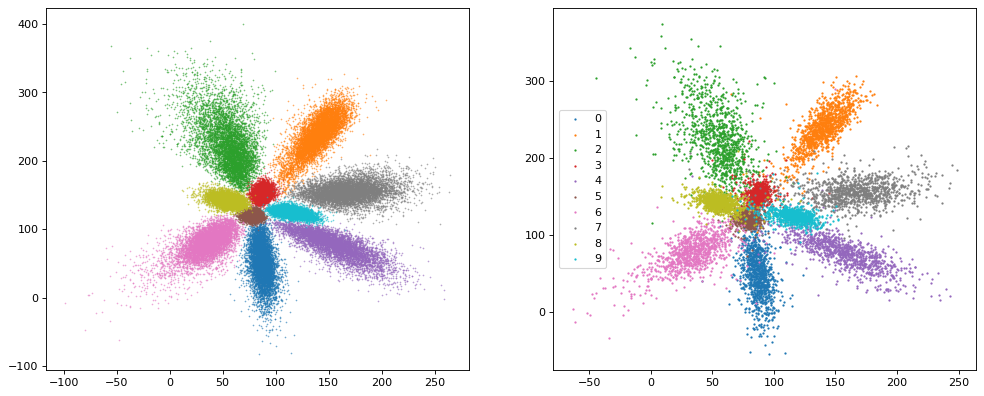

In [8]:
classifier_with_features = FullyConnectedNet_features().to(device)
classifier_with_features.load_state_dict(classifier_fc.state_dict())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=len(train_data))
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data))

classifier_with_features.eval()

with torch.no_grad():
    images, train_labels = next(iter(train_loader))
    _, train_features = classifier_with_features(images.view(-1,28*28).to(device))
    train_features = train_features.cpu()

    images, test_labels = next(iter(test_loader))
    _, test_features = classifier_with_features(images.view(-1,28*28).to(device))
    test_features = test_features.cpu()

figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
for i in range(10): plt.scatter(train_features[train_labels==i].T[0], train_features[train_labels==i].T[1], c=clr[i], s=.1)

plt.subplot(122)
for i in range(10): plt.scatter(test_features[test_labels==i].T[0], test_features[test_labels==i].T[1], c=clr[i],s=1, label=f'{i}')
plt.legend()

# Similar excercise for CNN

In [9]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 32)
        self.fc2 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(2, 10)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm1d(2)
        self.bn3 = nn.BatchNorm1d(32)

    def forward(self,x):
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.relu(out)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.relu(out)
        out = self.bn2(out)
        out = out.view(out.size()[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.bn3(out)
        out = self.fc2(out)
        features = out
        out = self.relu(out)
        out = self.bn4(out)        
        out = self.fc3(out) 
        return out, features

In [10]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(28, 28)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root='./data', train=True, transform=data_transforms, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=data_transforms, download=True)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [11]:
cnn_classifier = CNNClassifier().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_classifier.parameters(), lr=0.1)

In [12]:
for epoch in range(num_epochs):
    running_loss_train = 0.
    running_corrects_train = 0
    cnn_classifier.train()
    for i ,(images,labels) in enumerate(train_loader):    
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, features = cnn_classifier(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss_train += loss.item() * images.size(0)
        running_corrects_train += torch.sum(preds == labels.data)
    epoch_loss_train = running_loss_train / len(train_data)
    epoch_acc_train = running_corrects_train.double() / len(train_data)

    cnn_classifier.eval()
    running_loss_test = 0.
    running_corrects_test = 0
    for i ,(images,labels) in enumerate(test_loader):    
        images = images.to(device)
        labels = labels.to(device)
        outputs, features = cnn_classifier(images)
        loss = loss_function(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss_test += loss.item() * images.size(0)
        running_corrects_test += torch.sum(preds == labels.data)
    epoch_loss_test = running_loss_test / len(test_data)
    epoch_acc_test = running_corrects_test.double() / len(test_data)         

    print(f'Epoch {epoch+1}/{num_epochs}\t'
          f'Train loss: {epoch_loss_train:.4f} | '
          f'Train accuracy: {epoch_acc_train:.4f} | '
          f'Test loss: {epoch_loss_test:.4f} | '
          f'Test accuracy: {epoch_acc_test:.4f}')

Epoch 1/50	Train loss: 1.6918 | Train accuracy: 0.3663 | Test loss: 3.9872 | Test accuracy: 0.2815
Epoch 2/50	Train loss: 0.8905 | Train accuracy: 0.6982 | Test loss: 2.4895 | Test accuracy: 0.3661
Epoch 3/50	Train loss: 0.5661 | Train accuracy: 0.7877 | Test loss: 1.6049 | Test accuracy: 0.5002
Epoch 4/50	Train loss: 0.4078 | Train accuracy: 0.8837 | Test loss: 0.5444 | Test accuracy: 0.8180
Epoch 5/50	Train loss: 0.2785 | Train accuracy: 0.9360 | Test loss: 0.3865 | Test accuracy: 0.9041
Epoch 6/50	Train loss: 0.2212 | Train accuracy: 0.9520 | Test loss: 0.2968 | Test accuracy: 0.9297
Epoch 7/50	Train loss: 0.1814 | Train accuracy: 0.9613 | Test loss: 0.1798 | Test accuracy: 0.9649
Epoch 8/50	Train loss: 0.1555 | Train accuracy: 0.9664 | Test loss: 0.1738 | Test accuracy: 0.9638
Epoch 9/50	Train loss: 0.1347 | Train accuracy: 0.9706 | Test loss: 0.1965 | Test accuracy: 0.9605
Epoch 10/50	Train loss: 0.1236 | Train accuracy: 0.9731 | Test loss: 0.2028 | Test accuracy: 0.9623
Epoch 11/

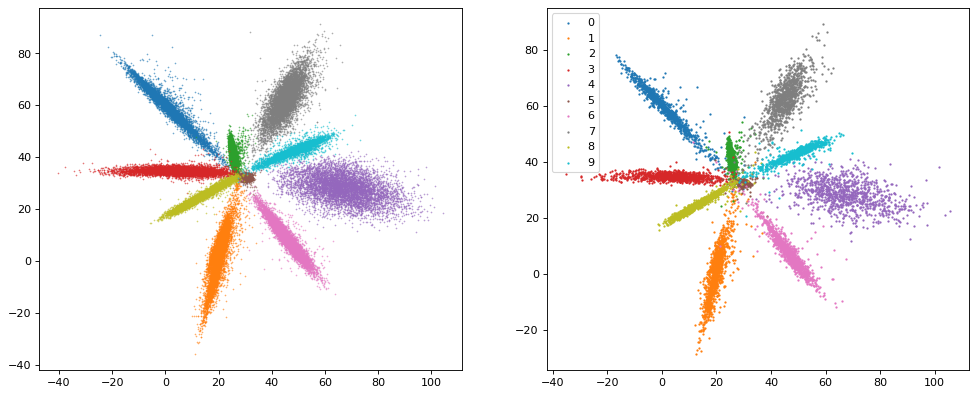

In [13]:
train_loader = DataLoader(dataset=train_data, batch_size=len(train_data))
test_loader = DataLoader(dataset=test_data, batch_size=len(test_data))
cnn_classifier.eval()

with torch.no_grad():
    images, train_labels = next(iter(train_loader))
    _, train_features = cnn_classifier(images.to(device))
    train_features = train_features.cpu()
    
    images, test_labels = next(iter(test_loader))
    _, test_features = cnn_classifier(images.to(device))
    test_features = test_features.cpu()


figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
for i in range(10): plt.scatter(train_features[train_labels==i].T[0], train_features[train_labels==i].T[1], c=clr[i], s=.1)

plt.subplot(122)
for i in range(10): plt.scatter(test_features[test_labels==i].T[0], test_features[test_labels==i].T[1], c=clr[i], s=1, label=f'{i}')
plt.legend()

# Siamese network -Training
- While training, we pass two images through CNN and calculate loss using embeddings of pair of image.
- forward method takes two images as input, passes each image through the same CNN and returns embeddings of each image

In [5]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.fc1 = nn.Linear(8*4*4, 2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self,x1, x2):
        out1 = self.conv1(x1)
        out1 = self.maxpool(out1)
        out1 = self.relu(out1)
        out1 = self.bn1(out1)
        out1 = self.conv2(out1)
        out1 = self.maxpool(out1)
        out1 = self.relu(out1)
        out1 = self.bn2(out1)
        out1 = out1.view(out1.size()[0], -1)
        out1 = self.fc1(out1)
        
        out2 = self.conv1(x2)
        out2 = self.maxpool(out2)
        out2 = self.relu(out2)
        out2 = self.bn1(out2)
        out2 = self.conv2(out2)
        out2 = self.maxpool(out2)
        out2 = self.relu(out2)
        out2 = self.bn2(out2)
        out2 = out2.view(out2.size()[0], -1)
        out2 = self.fc1(out2)

        return out1, out2

## Dataset class
- returns pair of images with label indicating if pair is positive(simialr) or negative(disimilar)

In [8]:
class siameseMNIST(Dataset):
    def __init__(self, phase):
        self.samples = []
        self.phase = phase
        self.train_indices = []
        self.test_indices = []
        for i in range(10):
            self.train_indices.append([x for x, item in enumerate(train_data.targets == i) if item])
            self.test_indices.append([x for x, item in enumerate(test_data.targets == i) if item])

    def __getitem__(self, index):
        if self.phase == 'train':
            x1, label = train_data.__getitem__(index)
            if random.random() > 0.5:
                x2, _ = train_data.__getitem__(random.choice(self.train_indices[label]))
                pair_label = 1
            else:
                all_classes = list(range(10))
                _ = all_classes.pop(label)
                diff_class = random.choice(all_classes)
                x2, _ = train_data.__getitem__(random.choice(self.train_indices[diff_class]))
                pair_label = 0
            return x1, x2, pair_label 

        else:
            x1, label = test_data.__getitem__(index)
            if random.random() > 0.5:
                x2, _ = test_data.__getitem__(random.choice(self.test_indices[label]))
                pair_label = 1
            else:
                all_classes = list(range(10))
                _ = all_classes.pop(label)
                diff_class = random.choice(all_classes)
                x2, _ = test_data.__getitem__(random.choice(self.test_indices[diff_class]))
                pair_label = 0
            return x1, x2, pair_label

    def __len__(self):
        if self.phase == 'train': return 60000
        return 10000

In [9]:
siamese_train_data = siameseMNIST(phase='train')
siamese_test_data = siameseMNIST(phase='test')

train_loader = DataLoader(dataset=siamese_train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=siamese_test_data, batch_size=batch_size, shuffle=False)

## Contrastive Loss

In [10]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target):
        distances = (output2 - output1).pow(2).sum(1)
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean()

In [11]:
siamese_net = SiameseNet().to(device)
loss_function = ContrastiveLoss(1.)
optimizer = torch.optim.Adam(siamese_net.parameters(), lr=1e-1)

In [12]:
for epoch in range(num_epochs):
    siamese_net.train()
    running_loss_train = 0.
    for i ,(images_1, images_2,labels) in enumerate(train_loader):    
        images_1 = images_1.to(device)
        images_2 = images_2.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output_1, output_2 = siamese_net(images_1, images_2)
        loss = loss_function(output_1, output_2, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * images_1.size(0)
    epoch_loss_train = running_loss_train / len(siamese_train_data)

    siamese_net.eval()
    running_loss_test = 0.
    for i ,(images_1, images_2,labels) in enumerate(test_loader):    
        images_1 = images_1.to(device)
        images_2 = images_2.to(device)
        labels = labels.to(device)
        output_1, output_2 = siamese_net(images_1, images_2)
        loss = loss_function(output_1, output_2, labels)
        running_loss_test += loss.item() * images_1.size(0)
    epoch_loss_test = running_loss_test / len(siamese_test_data)

    print(f'Epoch {epoch+1}/{num_epochs} | '
          f'Train loss: {epoch_loss_train} | '
          f'Test loss: {epoch_loss_test}')
    

Epoch 1/50 | Train loss: 0.32793956224521004 | Test loss: 0.15159297547340392
Epoch 2/50 | Train loss: 0.11241169253190358 | Test loss: 0.10518390167951584
Epoch 3/50 | Train loss: 0.09603521345853805 | Test loss: 0.09020883156061173
Epoch 4/50 | Train loss: 0.0877541241923968 | Test loss: 0.0836599080324173
Epoch 5/50 | Train loss: 0.08124763851165771 | Test loss: 0.07818824492692947
Epoch 6/50 | Train loss: 0.07535659827788671 | Test loss: 0.07015382513999939
Epoch 7/50 | Train loss: 0.07075188776254654 | Test loss: 0.06570579954385758
Epoch 8/50 | Train loss: 0.06690301154454549 | Test loss: 0.06283991255164147
Epoch 9/50 | Train loss: 0.06371260044972102 | Test loss: 0.060857792752981185
Epoch 10/50 | Train loss: 0.06066430602073669 | Test loss: 0.058408851450681684
Epoch 11/50 | Train loss: 0.05838836973508199 | Test loss: 0.055152521997690204
Epoch 12/50 | Train loss: 0.05678285438021024 | Test loss: 0.05569496013522148
Epoch 13/50 | Train loss: 0.05522875743707021 | Test loss: 0

# Class for test-time siamese

In [13]:
class siamese_test(nn.Module):
    def __init__(self):
        super(siamese_test,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.fc1 = nn.Linear(8*4*4, 2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self,x1):
        out1 = self.conv1(x1)
        out1 = self.maxpool(out1)
        out1 = self.relu(out1)
        out1 = self.bn1(out1)
        out1 = self.conv2(out1)
        out1 = self.maxpool(out1)
        out1 = self.relu(out1)
        out1 = self.bn2(out1)
        out1 = out1.view(out1.size()[0], -1)
        out1 = self.fc1(out1)
        return out1

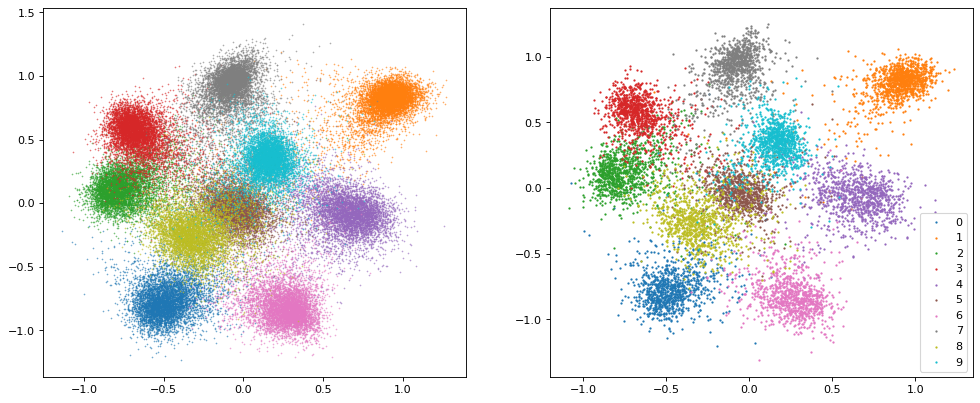

In [16]:
siamese_test_net = siamese_test().to(device)
siamese_test_net.load_state_dict(siamese_net.state_dict())

train_loader = DataLoader(dataset=train_data, batch_size=len(train_data))
test_loader = DataLoader(dataset=test_data, batch_size=len(test_data))

siamese_test_net.eval()

with torch.no_grad():
    images, train_labels = next(iter(train_loader))
    train_features = siamese_test_net(images.to(device))
    train_features = train_features.cpu()
    
    images, test_labels = next(iter(test_loader))
    test_features = siamese_test_net(images.to(device))
    test_features = test_features.cpu()

figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
for i in range(10): plt.scatter(train_features[train_labels==i].T[0], train_features[train_labels==i].T[1], c=clr[i], s=.1)

plt.subplot(122)
for i in range(10): plt.scatter(test_features[test_labels==i].T[0], test_features[test_labels==i].T[1], c=clr[i], s=1, label=f'{i}')
plt.legend()

# Triplet loss

In [22]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [23]:
class tripletMNIST(Dataset):
    def __init__(self, phase):
        self.samples = []
        self.phase = phase
        self.train_indices = []
        self.test_indices = []
        for i in range(10):
            self.train_indices.append([x for x, item in enumerate(train_data.targets == i) if item])
            self.test_indices.append([x for x, item in enumerate(test_data.targets == i) if item])

    def __getitem__(self, index):
        if self.phase == 'train':
            anchor, label = train_data.__getitem__(index) ## __getitem__ of MNIST dataset class
            pos, _ = train_data.__getitem__(random.choice(self.train_indices[label]))
            all_classes = list(range(10))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = train_data.__getitem__(random.choice(self.train_indices[diff_class]))
            return anchor, pos, neg

        if self.phase == 'test':
            anchor, label = test_data.__getitem__(index)
            pos, _ = test_data.__getitem__(random.choice(self.test_indices[label]))
            all_classes = list(range(10))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = test_data.__getitem__(random.choice(self.test_indices[diff_class]))
            return anchor, pos, neg
            
    def __len__(self):
        if self.phase == 'train': return 60000
        return 10000

In [24]:
triplet_train_data = tripletMNIST(phase='train')
triplet_test_data = tripletMNIST(phase='test')

train_loader = DataLoader(dataset=triplet_train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=triplet_test_data, batch_size=batch_size, shuffle=False)

In [25]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.fc1 = nn.Linear(8*4*4, 2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self, anchor, pos, neg):
        anchor_embd = self.conv1(anchor)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn1(anchor_embd)
        anchor_embd = self.conv2(anchor_embd)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn2(anchor_embd)
        anchor_embd = anchor_embd.view(anchor_embd.size()[0], -1)
        anchor_embd = self.fc1(anchor_embd)

        pos_embd = self.conv1(pos)
        pos_embd = self.maxpool(pos_embd)
        pos_embd = self.relu(pos_embd)
        pos_embd = self.bn1(pos_embd)
        pos_embd = self.conv2(pos_embd)
        pos_embd = self.maxpool(pos_embd)
        pos_embd = self.relu(pos_embd)
        pos_embd = self.bn2(pos_embd)
        pos_embd = pos_embd.view(pos_embd.size()[0], -1)
        pos_embd = self.fc1(pos_embd)

        neg_embd = self.conv1(neg)
        neg_embd = self.maxpool(neg_embd)
        neg_embd = self.relu(neg_embd)
        neg_embd = self.bn1(neg_embd)
        neg_embd = self.conv2(neg_embd)
        neg_embd = self.maxpool(neg_embd)
        neg_embd = self.relu(neg_embd)
        neg_embd = self.bn2(neg_embd)
        neg_embd = neg_embd.view(neg_embd.size()[0], -1)
        neg_embd = self.fc1(neg_embd)

        return anchor_embd, pos_embd, neg_embd

In [26]:
triplet_net = TripletNet().to(device)
loss_function = TripletLoss(1.)
optimizer = torch.optim.Adam(triplet_net.parameters(), lr=1e-1)

In [27]:
for epoch in range(num_epochs):
    triplet_net.train()
    running_loss_train = 0.
    for i ,(anchor, pos, neg) in enumerate(train_loader):  
        anchor = anchor.to(device)
        pos = pos.to(device)
        neg = neg.to(device)
        optimizer.zero_grad()
        anchor_embd, pos_embd, neg_embd = triplet_net(anchor, pos, neg)
        loss = loss_function(anchor_embd, pos_embd, neg_embd)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * anchor.size(0)
    epoch_loss_train = running_loss_train / len(triplet_train_data)

    triplet_net.eval()
    running_loss_test = 0.
    for i ,(anchor, pos, neg) in enumerate(test_loader):  
        anchor = anchor.to(device)
        pos = pos.to(device)
        neg = neg.to(device)
        anchor_embd, pos_embd, neg_embd = triplet_net(anchor, pos, neg)
        loss = loss_function(anchor_embd, pos_embd, neg_embd)
        running_loss_test += loss.item() * anchor.size(0)
    epoch_loss_test = running_loss_test / len(triplet_test_data)

    print(f'Epoch {epoch+1}/{num_epochs} | '
        f'Train loss: {epoch_loss_train} | '
        f'Test loss: {epoch_loss_test}')

Epoch 1/50 | Train loss: 0.8537684236208598 | Test loss: 0.4324006450176239
Epoch 2/50 | Train loss: 0.3947213595231374 | Test loss: 0.34088681445121766
Epoch 3/50 | Train loss: 0.32885092116991677 | Test loss: 0.2886529051780701
Epoch 4/50 | Train loss: 0.284625927623113 | Test loss: 0.24772856419086456
Epoch 5/50 | Train loss: 0.24795100762844086 | Test loss: 0.21647883071899415
Epoch 6/50 | Train loss: 0.22758726357618966 | Test loss: 0.21156237120628357
Epoch 7/50 | Train loss: 0.2111462652762731 | Test loss: 0.19775801420211792
Epoch 8/50 | Train loss: 0.19674607915083567 | Test loss: 0.18393217241764068
Epoch 9/50 | Train loss: 0.18423305546442667 | Test loss: 0.17851806147098542
Epoch 10/50 | Train loss: 0.17154831115404764 | Test loss: 0.16434665248394012
Epoch 11/50 | Train loss: 0.16657937575976053 | Test loss: 0.1535630228281021
Epoch 12/50 | Train loss: 0.15785883144537607 | Test loss: 0.15333408765792847
Epoch 13/50 | Train loss: 0.15224661926428476 | Test loss: 0.14086706

In [28]:
class TripletNetTest(nn.Module):
    def __init__(self):
        super(TripletNetTest,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.fc1 = nn.Linear(8*4*4, 2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self, anchor):
        anchor_embd = self.conv1(anchor)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn1(anchor_embd)
        anchor_embd = self.conv2(anchor_embd)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn2(anchor_embd)
        anchor_embd = anchor_embd.view(anchor_embd.size()[0], -1)
        anchor_embd = self.fc1(anchor_embd)
        return anchor_embd

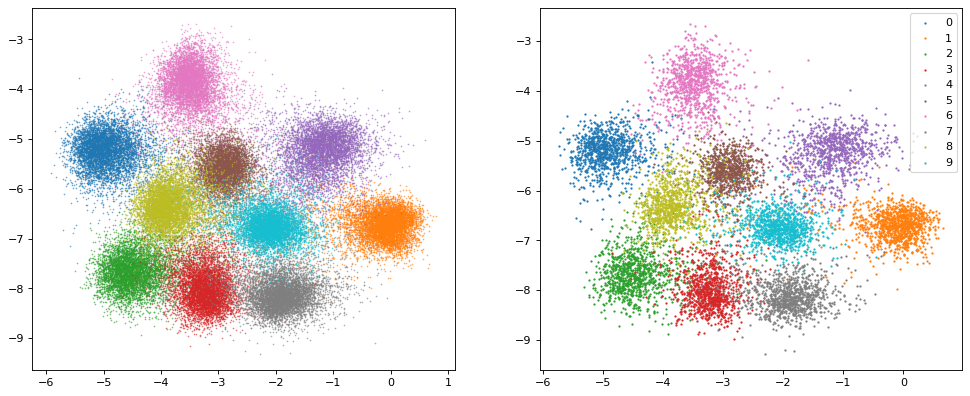

In [29]:
triplet_test_net = TripletNetTest().to(device)
triplet_test_net.load_state_dict(triplet_net.state_dict())

train_loader = DataLoader(dataset=train_data, batch_size=len(train_data))
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data))
triplet_test_net.eval()

with torch.no_grad():
    images, train_labels = next(iter(train_loader))
    train_features = triplet_test_net(images.to(device))
    train_features = train_features.cpu()
    
    images, test_labels = next(iter(test_loader))
    test_features = triplet_test_net(images.to(device))
    test_features = test_features.cpu()


figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
for i in range(10): plt.scatter(train_features[train_labels==i].T[0], train_features[train_labels==i].T[1], c=clr[i], s=.1)

plt.subplot(122)
for i in range(10): plt.scatter(test_features[test_labels==i].T[0], test_features[test_labels==i].T[1], c=clr[i], s=1, label=f'{i}')
plt.legend()

# Train on five classes, test on all

In [30]:
class tripletMNIST(Dataset):
    def __init__(self, phase):
        self.samples = []
        self.phase = phase
        self.train_indices = []
        self.test_indices = []
        for i in range(10):
            self.train_indices.append([x for x, item in enumerate(train_data.targets == i) if item])
            self.test_indices.append([x for x, item in enumerate(test_data.targets == i) if item])

    def __getitem__(self, index):
        if self.phase == 'train':
            anchor, label = train_data.__getitem__(index) ## __getitem__ of MNIST dataset class
            pos, _ = train_data.__getitem__(random.choice(self.train_indices[label]))
            all_classes = list(range(10))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = train_data.__getitem__(random.choice(self.train_indices[diff_class]))
            return anchor, pos, neg

        if self.phase == 'test':
            anchor, label = test_data.__getitem__(index)
            pos, _ = test_data.__getitem__(random.choice(self.test_indices[label]))
            all_classes = list(range(10))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = test_data.__getitem__(random.choice(self.test_indices[diff_class]))
            return anchor, pos, neg
            
    def __len__(self):
        if self.phase == 'train': return 60000
        return 10000

    

class tripletMNIST5(Dataset):
    def __init__(self, phase):
        self.samples = []
        self.phase = phase
        self.train_indices = []
        self.test_indices = []
        for i in range(5):
            self.train_indices.append([x for x, item in enumerate(train_data.targets == i) if item])
            self.test_indices.append([x for x, item in enumerate(test_data.targets == i) if item])

    def __getitem__(self, index):
        if self.phase == 'train':
            label = 9
            labels_ = [5,6,7,8,9]
            while label in labels_:
                anchor, label = train_data.__getitem__(index) ## __getitem__ of MNIST dataset class
                index = random.randint(0, 60000-1)
            pos, _ = train_data.__getitem__(random.choice(self.train_indices[label]))
            all_classes = list(range(5))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = train_data.__getitem__(random.choice(self.train_indices[diff_class]))
            return anchor, pos, neg

        if self.phase == 'test':
            label = 9
            labels_ = [5,6,7,8,9]
            while label in labels_:
                anchor, label = test_data.__getitem__(index)
                index = random.randint(0, 10000-1)
            pos, _ = test_data.__getitem__(random.choice(self.test_indices[label]))
            all_classes = list(range(5))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = test_data.__getitem__(random.choice(self.test_indices[diff_class]))
            return anchor, pos, neg
            
    def __len__(self):
        if self.phase == 'train': return 60000
        return 9000

In [31]:
triplet_train_data = tripletMNIST5(phase='train')
triplet_test_data = tripletMNIST5(phase='test')

train_loader = DataLoader(dataset=triplet_train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=triplet_test_data, batch_size=batch_size, shuffle=False)

In [32]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.fc1 = nn.Linear(8*4*4, 2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self, anchor, pos, neg):
        anchor_embd = self.conv1(anchor)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn1(anchor_embd)
        anchor_embd = self.conv2(anchor_embd)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn2(anchor_embd)
        anchor_embd = anchor_embd.view(anchor_embd.size()[0], -1)
        anchor_embd = self.fc1(anchor_embd)

        pos_embd = self.conv1(pos)
        pos_embd = self.maxpool(pos_embd)
        pos_embd = self.relu(pos_embd)
        pos_embd = self.bn1(pos_embd)
        pos_embd = self.conv2(pos_embd)
        pos_embd = self.maxpool(pos_embd)
        pos_embd = self.relu(pos_embd)
        pos_embd = self.bn2(pos_embd)
        pos_embd = pos_embd.view(pos_embd.size()[0], -1)
        pos_embd = self.fc1(pos_embd)

        neg_embd = self.conv1(neg)
        neg_embd = self.maxpool(neg_embd)
        neg_embd = self.relu(neg_embd)
        neg_embd = self.bn1(neg_embd)
        neg_embd = self.conv2(neg_embd)
        neg_embd = self.maxpool(neg_embd)
        neg_embd = self.relu(neg_embd)
        neg_embd = self.bn2(neg_embd)
        neg_embd = neg_embd.view(neg_embd.size()[0], -1)
        neg_embd = self.fc1(neg_embd)

        return anchor_embd, pos_embd, neg_embd

In [33]:
triplet_net = TripletNet().to(device)
loss_function = TripletLoss(1.)
optimizer = torch.optim.Adam(triplet_net.parameters(), lr=1e-1)

In [34]:
for epoch in range(num_epochs):
    triplet_net.train()
    running_loss_train = 0.
    for i ,(anchor, pos, neg) in enumerate(train_loader):  
        anchor = anchor.to(device)
        pos = pos.to(device)
        neg = neg.to(device)
        optimizer.zero_grad()
        anchor_embd, pos_embd, neg_embd = triplet_net(anchor, pos, neg)
        loss = loss_function(anchor_embd, pos_embd, neg_embd)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * anchor.size(0)
    epoch_loss_train = running_loss_train / len(triplet_train_data)

    triplet_net.eval()
    running_loss_test = 0.
    for i ,(anchor, pos, neg) in enumerate(test_loader):  
        anchor = anchor.to(device)
        pos = pos.to(device)
        neg = neg.to(device)
        anchor_embd, pos_embd, neg_embd = triplet_net(anchor, pos, neg)
        loss = loss_function(anchor_embd, pos_embd, neg_embd)
        running_loss_test += loss.item() * anchor.size(0)
    epoch_loss_test = running_loss_test / len(triplet_test_data)

    print(f'Epoch {epoch+1}/{num_epochs} | '
        f'Train loss: {epoch_loss_train} | '
        f'Test loss: {epoch_loss_test}')

Epoch 1/50 | Train loss: 0.9587710066954295 | Test loss: 0.21743546521663665
Epoch 2/50 | Train loss: 0.22662833954493206 | Test loss: 0.16266024974981944
Epoch 3/50 | Train loss: 0.15186840949455896 | Test loss: 0.09386988472276264
Epoch 4/50 | Train loss: 0.10364313699007034 | Test loss: 0.06623215487599372
Epoch 5/50 | Train loss: 0.0822462121963501 | Test loss: 0.0519715070757601
Epoch 6/50 | Train loss: 0.07123147489229838 | Test loss: 0.04944672141472498
Epoch 7/50 | Train loss: 0.06352440728545189 | Test loss: 0.04507361956768566
Epoch 8/50 | Train loss: 0.058998441024621325 | Test loss: 0.04203634409440888
Epoch 9/50 | Train loss: 0.054517082291841504 | Test loss: 0.03683737003803253
Epoch 10/50 | Train loss: 0.049231977053483325 | Test loss: 0.0330682518614663
Epoch 11/50 | Train loss: 0.04736873608430227 | Test loss: 0.039036446319686044
Epoch 12/50 | Train loss: 0.04293395170966784 | Test loss: 0.03085449254843924
Epoch 13/50 | Train loss: 0.040585013482968016 | Test loss: 0

In [35]:
class TripletNetTest(nn.Module):
    def __init__(self):
        super(TripletNetTest,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.fc1 = nn.Linear(8*4*4, 2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self, anchor):
        anchor_embd = self.conv1(anchor)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn1(anchor_embd)
        anchor_embd = self.conv2(anchor_embd)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn2(anchor_embd)
        anchor_embd = anchor_embd.view(anchor_embd.size()[0], -1)
        anchor_embd = self.fc1(anchor_embd)
        return anchor_embd

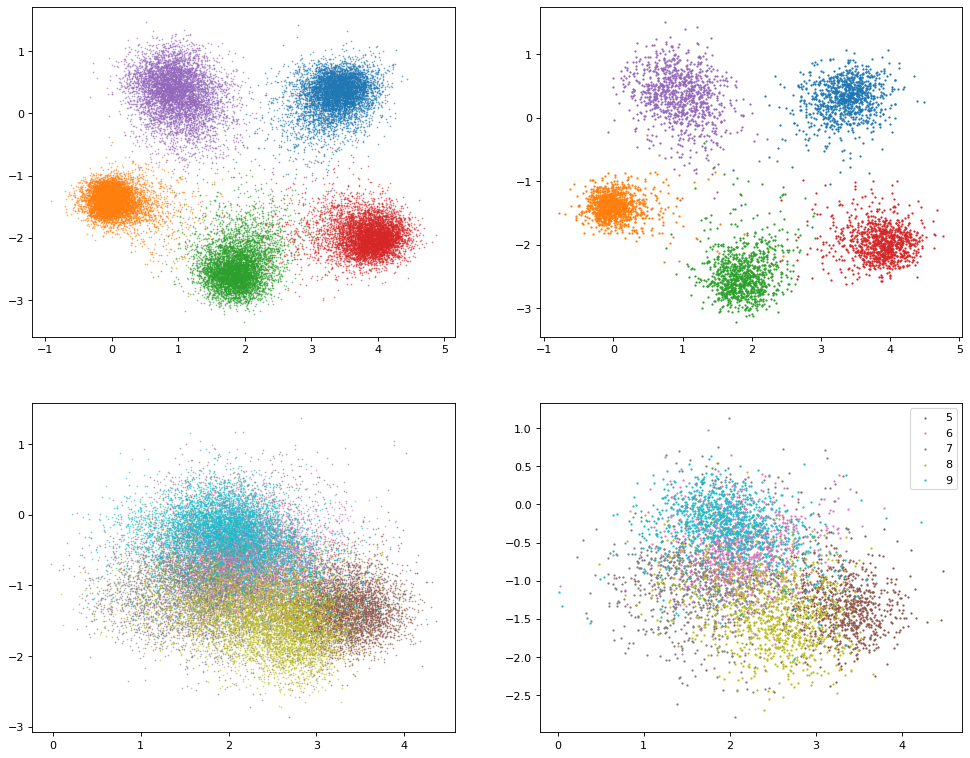

In [36]:
triplet_test_net = TripletNetTest().to(device)
triplet_test_net.load_state_dict(triplet_net.state_dict())

train_loader = DataLoader(dataset=train_data, batch_size=len(train_data))
test_loader = DataLoader(dataset=test_data, batch_size=len(test_data))
triplet_test_net.eval()

with torch.no_grad():
    images, train_labels = next(iter(train_loader))
    train_features = triplet_test_net(images.to(device))
    train_features = train_features.cpu()
    
    images, test_labels = next(iter(test_loader))
    test_features = triplet_test_net(images.to(device))
    test_features = test_features.cpu()


figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(221)
for i in range(5): plt.scatter(train_features[train_labels==i].T[0], train_features[train_labels==i].T[1], c=clr[i], s=.1)

plt.subplot(222)
for i in range(5): plt.scatter(test_features[test_labels==i].T[0], test_features[test_labels==i].T[1], c=clr[i], s=1, label=f'{i}')

plt.subplot(223)
for i in range(5, 10): plt.scatter(train_features[train_labels==i].T[0], train_features[train_labels==i].T[1], c=clr[i], s=.1)

plt.subplot(224)
for i in range(5, 10): plt.scatter(test_features[test_labels==i].T[0], test_features[test_labels==i].T[1], c=clr[i], s=1, label=f'{i}')
    
    
plt.legend()

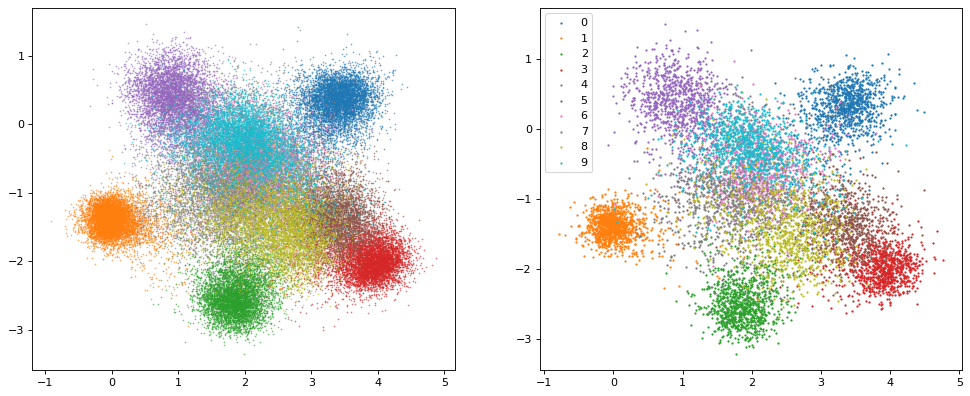

In [37]:
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
for i in range(10): plt.scatter(train_features[train_labels==i].T[0], train_features[train_labels==i].T[1], c=clr[i], s=.1)

plt.subplot(122)
for i in range(10): plt.scatter(test_features[test_labels==i].T[0], test_features[test_labels==i].T[1], c=clr[i], s=1, label=f'{i}')

plt.legend()

In [38]:
for i in range(5): print(train_features[train_labels==i].T[0].mean(), train_features[train_labels==i].T[1].mean())

tensor(3.3622) tensor(0.2980)
tensor(0.0460) tensor(-1.4054)
tensor(1.8836) tensor(-2.4422)
tensor(3.8262) tensor(-1.9684)
tensor(0.9725) tensor(0.3245)


In [39]:
torch.save(triplet_net.state_dict(), 'five_class_triplet.pt')

In [40]:
class tripletMNIST(Dataset):
    def __init__(self, phase):
        self.samples = []
        self.phase = phase
        self.train_indices = []
        self.test_indices = []
        for i in range(10):
            self.train_indices.append([x for x, item in enumerate(train_data.targets == i) if item])
            self.test_indices.append([x for x, item in enumerate(test_data.targets == i) if item])

    def __getitem__(self, index):
        if self.phase == 'train':
            anchor, label = train_data.__getitem__(index) ## __getitem__ of MNIST dataset class
            pos, _ = train_data.__getitem__(random.choice(self.train_indices[label]))
            all_classes = list(range(10))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = train_data.__getitem__(random.choice(self.train_indices[diff_class]))
            return anchor, pos, neg

        if self.phase == 'test':
            anchor, label = test_data.__getitem__(index)
            pos, _ = test_data.__getitem__(random.choice(self.test_indices[label]))
            all_classes = list(range(10))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = test_data.__getitem__(random.choice(self.test_indices[diff_class]))
            return anchor, pos, neg
            
    def __len__(self):
        if self.phase == 'train': return 60000
        return 10000

    

class tripletMNIST5(Dataset):
    def __init__(self, phase):
        self.samples = []
        self.phase = phase
        self.train_indices = []
        self.test_indices = []
        for i in range(5):
            self.train_indices.append([x for x, item in enumerate(train_data.targets == i) if item])
            self.test_indices.append([x for x, item in enumerate(test_data.targets == i) if item])

    def __getitem__(self, index):
        if self.phase == 'train':
            label = 9
            labels_ = [5,6,7,8,9]
            while label in labels_:
                anchor, label = train_data.__getitem__(index) ## __getitem__ of MNIST dataset class
                index = random.randint(0, 60000-1)
            pos, _ = train_data.__getitem__(random.choice(self.train_indices[label]))
            all_classes = list(range(5))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = train_data.__getitem__(random.choice(self.train_indices[diff_class]))
            return anchor, pos, neg

        if self.phase == 'test':
            label = 9
            labels_ = [5,6,7,8,9]
            while label in labels_:
                anchor, label = test_data.__getitem__(index)
                index = random.randint(0, 10000-1)
            pos, _ = test_data.__getitem__(random.choice(self.test_indices[label]))
            all_classes = list(range(5))
            _ = all_classes.pop(label)
            diff_class = random.choice(all_classes)
            neg, _ = test_data.__getitem__(random.choice(self.test_indices[diff_class]))
            return anchor, pos, neg
            
    def __len__(self):
        if self.phase == 'train': return 60000
        return 9000

In [41]:
triplet_train_data = tripletMNIST5(phase='train')
triplet_test_data = tripletMNIST5(phase='test')

train_loader = DataLoader(dataset=triplet_train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=triplet_test_data, batch_size=batch_size, shuffle=False)

In [42]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.fc1 = nn.Linear(8*4*4, 8)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self, anchor, pos, neg):
        anchor_embd = self.conv1(anchor)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn1(anchor_embd)
        anchor_embd = self.conv2(anchor_embd)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn2(anchor_embd)
        anchor_embd = anchor_embd.view(anchor_embd.size()[0], -1)
        anchor_embd = self.fc1(anchor_embd)

        pos_embd = self.conv1(pos)
        pos_embd = self.maxpool(pos_embd)
        pos_embd = self.relu(pos_embd)
        pos_embd = self.bn1(pos_embd)
        pos_embd = self.conv2(pos_embd)
        pos_embd = self.maxpool(pos_embd)
        pos_embd = self.relu(pos_embd)
        pos_embd = self.bn2(pos_embd)
        pos_embd = pos_embd.view(pos_embd.size()[0], -1)
        pos_embd = self.fc1(pos_embd)

        neg_embd = self.conv1(neg)
        neg_embd = self.maxpool(neg_embd)
        neg_embd = self.relu(neg_embd)
        neg_embd = self.bn1(neg_embd)
        neg_embd = self.conv2(neg_embd)
        neg_embd = self.maxpool(neg_embd)
        neg_embd = self.relu(neg_embd)
        neg_embd = self.bn2(neg_embd)
        neg_embd = neg_embd.view(neg_embd.size()[0], -1)
        neg_embd = self.fc1(neg_embd)

        return anchor_embd, pos_embd, neg_embd

In [43]:
triplet_net = TripletNet().to(device)
loss_function = TripletLoss(1.)
optimizer = torch.optim.Adam(triplet_net.parameters(), lr=1e-1)

In [44]:
for epoch in range(num_epochs):
    triplet_net.train()
    running_loss_train = 0.
    for i ,(anchor, pos, neg) in enumerate(train_loader):  
        anchor = anchor.to(device)
        pos = pos.to(device)
        neg = neg.to(device)
        optimizer.zero_grad()
        anchor_embd, pos_embd, neg_embd = triplet_net(anchor, pos, neg)
        loss = loss_function(anchor_embd, pos_embd, neg_embd)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * anchor.size(0)
    epoch_loss_train = running_loss_train / len(triplet_train_data)

    triplet_net.eval()
    running_loss_test = 0.
    for i ,(anchor, pos, neg) in enumerate(test_loader):  
        anchor = anchor.to(device)
        pos = pos.to(device)
        neg = neg.to(device)
        anchor_embd, pos_embd, neg_embd = triplet_net(anchor, pos, neg)
        loss = loss_function(anchor_embd, pos_embd, neg_embd)
        running_loss_test += loss.item() * anchor.size(0)
    epoch_loss_test = running_loss_test / len(triplet_test_data)

    print(f'Epoch {epoch+1}/{num_epochs} | '
        f'Train loss: {epoch_loss_train} | '
        f'Test loss: {epoch_loss_test}')

Epoch 1/50 | Train loss: 1.363394708077113 | Test loss: 0.14172860353522831
Epoch 2/50 | Train loss: 0.16086737194856007 | Test loss: 0.08529353756374783
Epoch 3/50 | Train loss: 0.08676283853848775 | Test loss: 0.06109595936536789
Epoch 4/50 | Train loss: 0.06187658966183662 | Test loss: 0.04456925508048799
Epoch 5/50 | Train loss: 0.05340406612157822 | Test loss: 0.03707871832615799
Epoch 6/50 | Train loss: 0.047042045547564824 | Test loss: 0.03935875788827737
Epoch 7/50 | Train loss: 0.04245476124087969 | Test loss: 0.03246390627821286
Epoch 8/50 | Train loss: 0.03989591744740804 | Test loss: 0.03139084191289213
Epoch 9/50 | Train loss: 0.03667348067859809 | Test loss: 0.028676401944624053
Epoch 10/50 | Train loss: 0.03477293784618378 | Test loss: 0.028890689844886464
Epoch 11/50 | Train loss: 0.033201525461673737 | Test loss: 0.029421074541078673
Epoch 12/50 | Train loss: 0.03320458493729432 | Test loss: 0.023144002670215234
Epoch 13/50 | Train loss: 0.030715131266911826 | Test los

In [45]:
class TripletNetTest(nn.Module):
    def __init__(self):
        super(TripletNetTest,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.fc1 = nn.Linear(8*4*4, 8)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self, anchor):
        anchor_embd = self.conv1(anchor)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn1(anchor_embd)
        anchor_embd = self.conv2(anchor_embd)
        anchor_embd = self.maxpool(anchor_embd)
        anchor_embd = self.relu(anchor_embd)
        anchor_embd = self.bn2(anchor_embd)
        anchor_embd = anchor_embd.view(anchor_embd.size()[0], -1)
        anchor_embd = self.fc1(anchor_embd)
        return anchor_embd

In [46]:
triplet_test_net = TripletNetTest().to(device)
triplet_test_net.load_state_dict(triplet_net.state_dict())

train_loader = DataLoader(dataset=train_data, batch_size=len(train_data))
test_loader = DataLoader(dataset=test_data, batch_size=len(test_data))
triplet_test_net.eval()

with torch.no_grad():
    images, train_labels = next(iter(train_loader))
    train_features = triplet_test_net(images.to(device))
    train_features = train_features.cpu()
    
    images, test_labels = next(iter(test_loader))
    test_features = triplet_test_net(images.to(device))
    test_features = test_features.cpu()

In [47]:
torch.mean(train_features, dim=0)

tensor([ 1.9719,  6.7242, -0.2556, -2.1031,  9.4787, -2.4546, -3.9053,  0.1855])

In [48]:
for i in range(5): print(train_features[train_labels==i].T[0].mean(), train_features[train_labels==i].T[1].mean())

tensor(2.3359) tensor(7.4730)
tensor(2.8240) tensor(6.4540)
tensor(2.3051) tensor(6.8923)
tensor(1.4901) tensor(6.6318)
tensor(1.7020) tensor(6.3526)


In [49]:
for i in range(5): print(torch.mean(train_features[train_labels==i], dim=0))

tensor([ 2.3359,  7.4730, -0.0336, -1.7001,  9.1404, -4.0591, -4.5533, -0.1032])
tensor([ 2.8240,  6.4540,  0.2973, -2.7745, 10.3421, -1.2848, -4.5203,  0.3977])
tensor([ 2.3051,  6.8923, -0.6625, -1.9963,  8.5990, -2.0229, -4.1057,  1.4288])
tensor([ 1.4901,  6.6318, -0.7187, -1.9118,  8.7898, -1.4934, -3.5838, -0.7814])
tensor([ 1.7020,  6.3526,  0.1488, -2.6294, 10.6241, -3.0275, -3.1699,  0.7569])


In [50]:
torch.save(triplet_net.state_dict(), 'mnist_triplet_8__.pt')